In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
import cmocean
from scipy.interpolate import interp1d
from scipy import interpolate
from numba import autojit
from pylab import *
from matplotlib import gridspec
import netCDF4
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from useful import *
from Flat_channel import *
from HB_Plot import nf, fmt
import SG as SG
import layers_calc
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

In [7]:
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis'
# Now Make file structure
tau = ['/Part2/L90_closed/', '/Part2/L90_tref_closed/','/Extra/AC14restoring_KPP_closed/3dayflat/','/Closeddaynokpp/']
Runs=np.array(tau)
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']

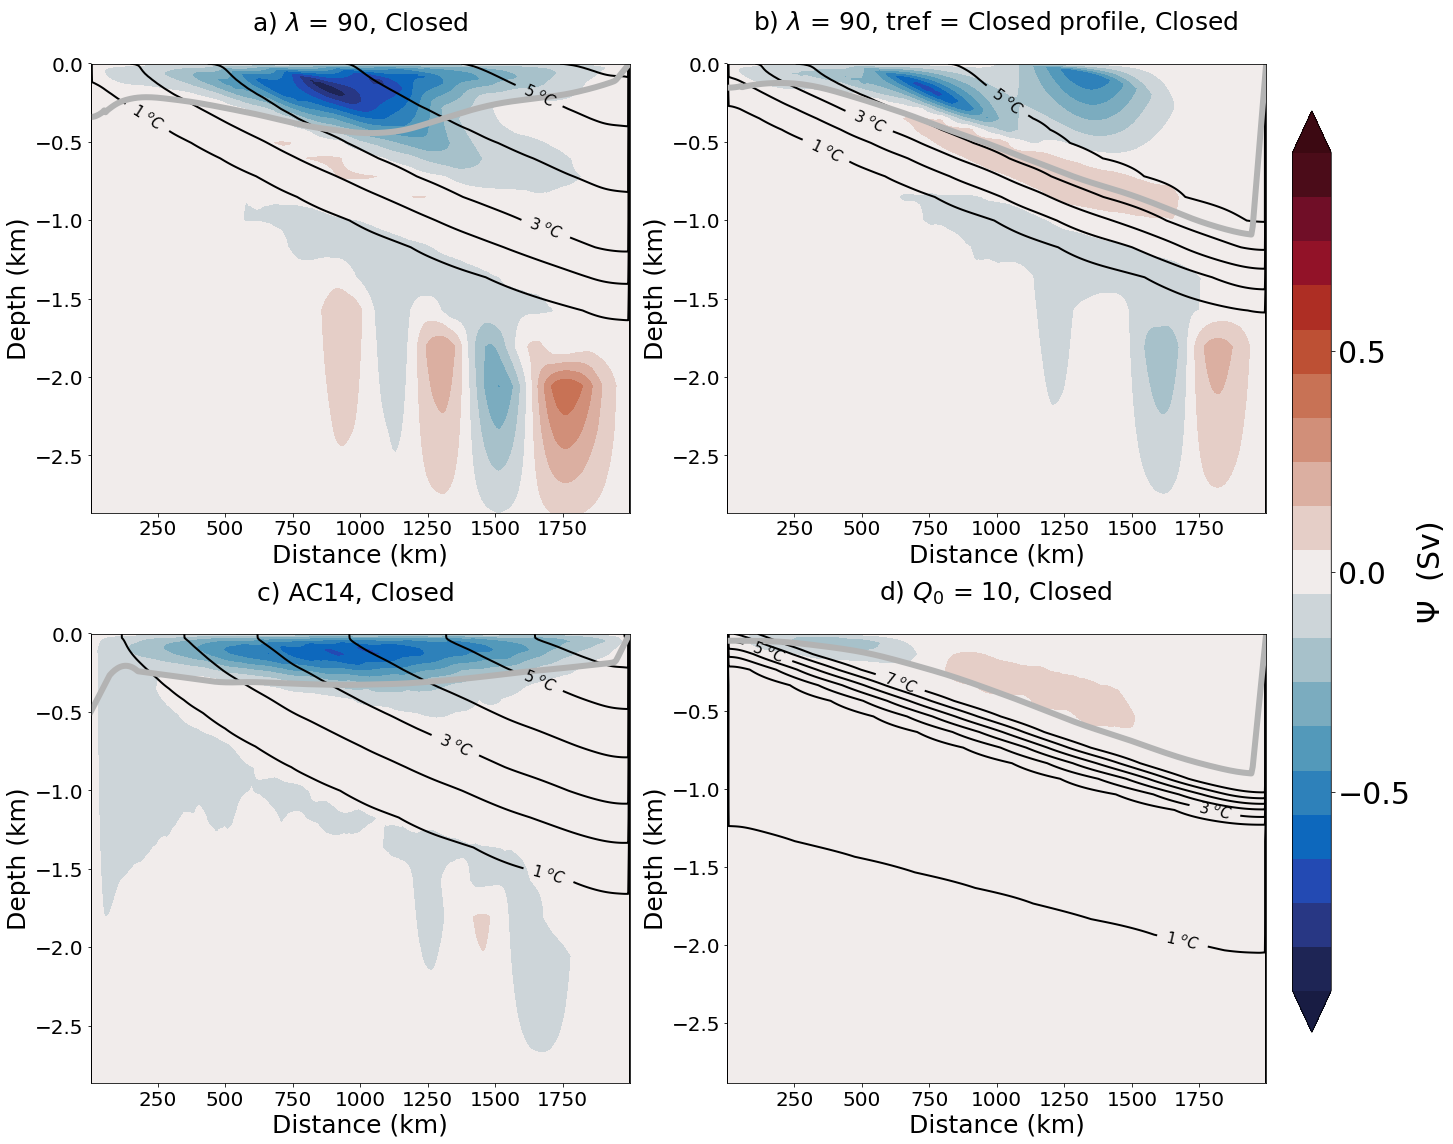

In [3]:
fig = plt.figure(figsize=(18.0, 16.))
# Create Panels

Psi_levs = np.arange(-1., 1., .1)+0.05
Psi_ticks =np.arange(-1., 1., .5)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q_levs = arange(-1,8,1)

for i in range(len(Runs)):
   
    fname = x+str(Runs[i])
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS

    Psi = c.get_psi_iso_z()/10**6
    g = layers_calc.LayersComputer(c)
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    PIz = g.transform_g_to_z(PI,th)
    #PIz[-5::,50::]=np.nan
    ax = fig.add_subplot(2, 2, i+1)
    p = ax.contourf(c.yc/1000, c.zc/1000,
                Psi, Psi_levs, cmap=cmocean.cm.balance, extend='both')
    q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc','THETA'), Q_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=15)
    # Plot mixed layer depth via layer probability
    val = 0
    if i==2:
        val=100
    mld = c.mnc('MLD.nc','MXLDEPTH')[0,:,:].mean(axis=1)
    mld[0:val] = np.linspace(200,mld[val],val)
    mld[0:val/4] = np.linspace(500,100,val/4)
    R = ax.plot(c.yc/1000, SG.savitzky_golay(-mld/1000, 21, 1), scalex=False,
                scaley=False, color='0.7', linestyle='-', linewidth=6)
    if str(Figletter[i])=='a) ':
        ax.set_title(str(Figletter[i])+r'$\lambda $ = 90, Closed'+'\n', fontsize=25)
    elif str(Figletter[i])=='b) ':
        ax.set_title(str(Figletter[i])+'$\lambda $ = 90, tref = Closed profile, Closed \n', fontsize=25)
    elif str(Figletter[i])=='c) ':
        ax.set_title(str(Figletter[i])+'AC14, Closed \n', fontsize=25)
    elif str(Figletter[i])=='d) ':
        ax.set_title(str(Figletter[i])+'$Q_0 $ = 10, Closed \n', fontsize=25)
    ax.set_xlabel('Distance (km)', fontsize=25)
    ax.set_ylabel('Depth (km)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('$\Psi$  (Sv)', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in greater
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in less
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in divide


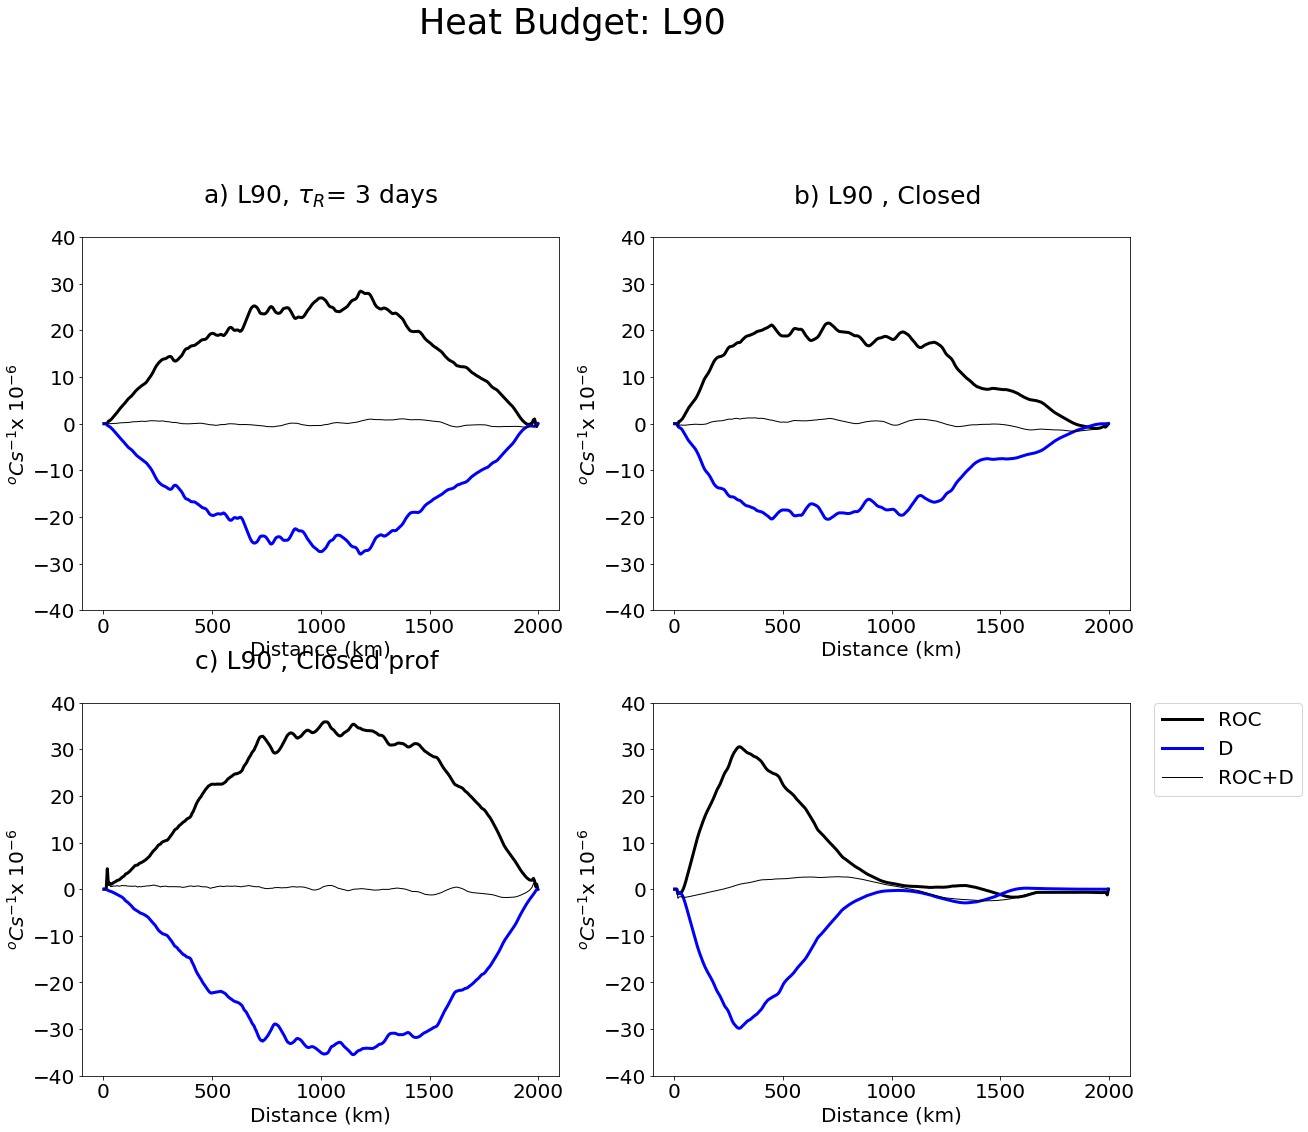

In [14]:

fig = plt.figure(figsize=(16.0, 16.))
for i in range(len(Runs)):
    
    fname = x+str(Runs[i])
    c = utils.ChannelSetup(output_dir=str(fname))
    ax = fig.add_subplot(2, 2, i+1)
    nopart = c. HFacC
    nopart[nopart<1] = 0
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T*nopart

    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    #Sp[abs(Sp)<10**-6]=10**-6
    Sp[Sp>1]=1
    Sp[Sp<-1]=-1
    Sp[isinf(Sp)]=10**-6
    Sp[isnan(Sp)]=10**-6
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1,:,:])*CellVol[0:-1,:,:] 
    DE = ((c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[1::,:,:] 
          - (c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[0:-1,:,:])*CellVol[0:-1,:,:] 
    # Surface cor
    # Surf_corr_tend = (- WTHMASS(ix,iy)) / (DRF(1) * hFacC(ix,iy,1)
    Surcor = -(WTHMASS.mean(axis=0)).mean(axis=1)*c.dzf[0]
    npad = ((0, 1), (0, 0), (0, 0))
    DE = np.pad(DE, pad_width=npad, mode='constant', constant_values=0)

    ROC = -((np.nansum(Ade,axis=0) + dVTe.sum(axis=0) + dVTbar.sum(axis=0) + dWTbar.sum(axis=0)).sum(axis=1))/sum(CellVol.mean(axis=2))
 
    D = -((((DE )).sum(axis=2)).sum(axis=0))/sum(CellVol.mean(axis=2))
    # Tidy for boundary conditions
    ROC[0:3] = 0
    D[0:3] = 0
    # Surface Heat Flux in W/m**2
    Q = c.mnc('SURF.nc', 'TFLUX').mean(axis=0).mean(axis=1)

    Psipred = -np.nan*(Q)/(1000*3985)
    p = plt.plot(c.yc/1000,(ROC)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(D)*10**6,'b',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC+D+Surcor)*10**6,'k',linewidth=1)
    plt.ylim(-40,40)
    if str(Figletter[i])=='a) ':
        ax.set_title(str(Figletter[i])+r'L90, $\tau _R $= 3 days'+'\n', fontsize=25)
    elif str(Figletter[i])=='b) ':
        ax.set_title(str(Figletter[i])+'L90 , Closed \n', fontsize=25)
    elif str(Figletter[i])=='c) ':
        ax.set_title(str(Figletter[i])+'L90 , Closed prof \n', fontsize=25)
    ax.set_xlabel('Distance (km)', fontsize=20)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
lgd=plt.legend([r'ROC','D','ROC+D',
                'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
fig.suptitle('Heat Budget: L90',fontsize=35)
fig.subplots_adjust(top=0.78)


/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in greater
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in less
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in divide


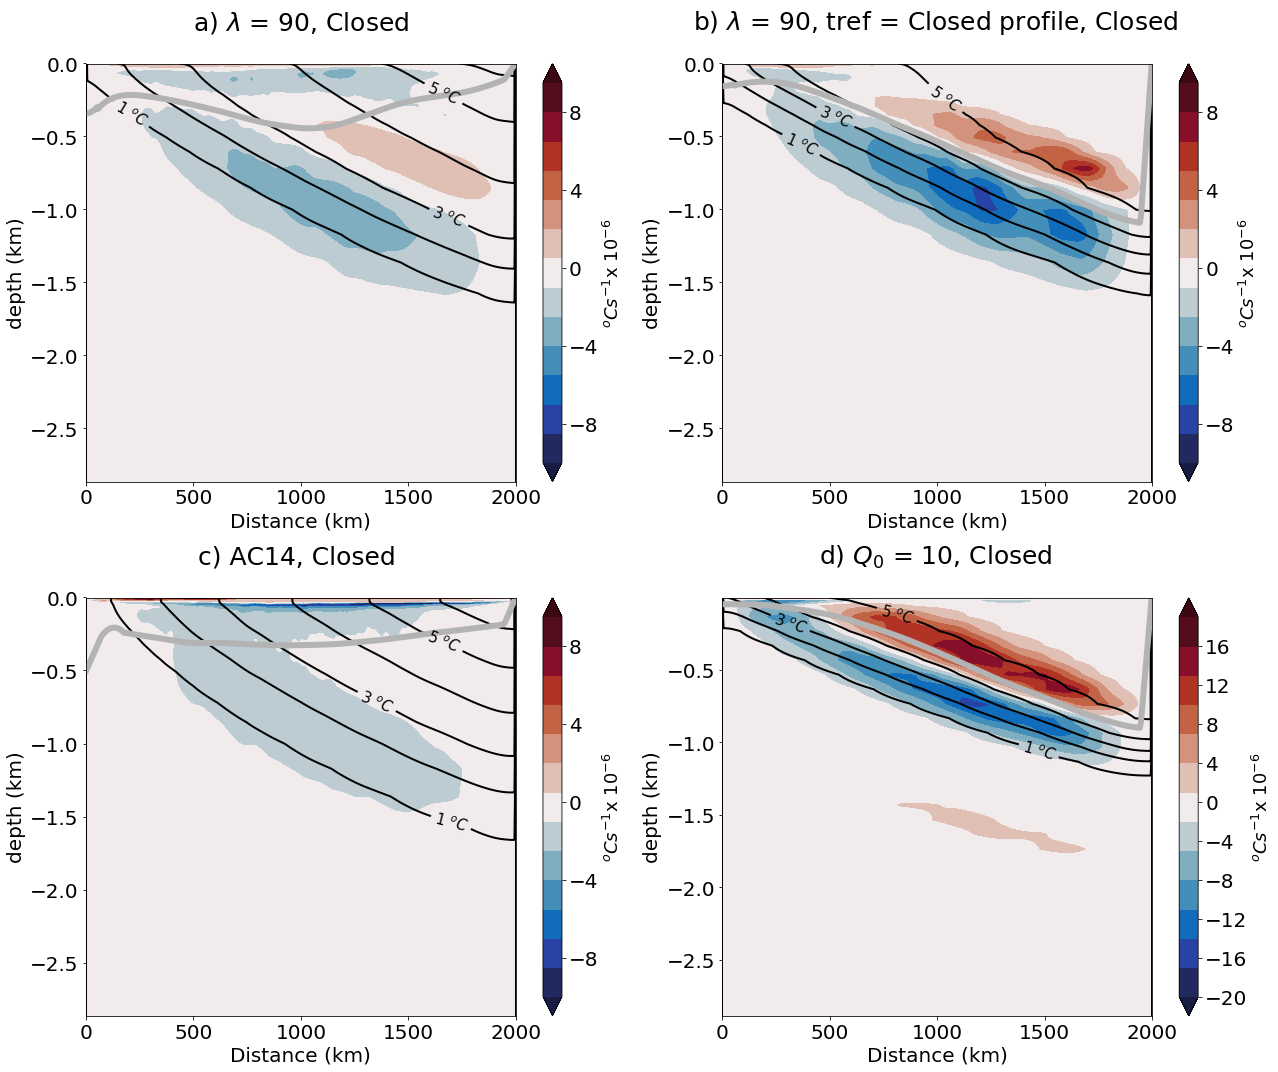

In [22]:
Psi_levs = np.arange(-2.5, 2.5, .2)+0.05
Psi_levs = np.arange(-2.5, 2.5, .2)+0.05
Psi_ticks =np.arange(-20., 20., 4)
fig = plt.figure(figsize=(18.0, 15.))
for i in range(len(Runs)):
    
    fname = x+str(Runs[i])
    c = utils.ChannelSetup(output_dir=str(fname))
    ax = fig.add_subplot(2, 2, i+1)
    nopart = c. HFacC
    nopart[nopart<1] = 0
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T*nopart

    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    #Sp[abs(Sp)<10**-6]=10**-6
    Sp[Sp>1]=1
    Sp[Sp<-1]=-1
    Sp[isinf(Sp)]=10**-6
    Sp[isnan(Sp)]=10**-6
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1,:,:])*CellVol[0:-1,:,:] 
    DE = ((c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[1::,:,:] 
          - (c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[0:-1,:,:])*CellVol[0:-1,:,:] 
    # Surface cor
    # Surf_corr_tend = (- WTHMASS(ix,iy)) / (DRF(1) * hFacC(ix,iy,1)
    Surcor = -(WTHMASS.mean(axis=0)).mean(axis=1)*c.dzf[0]
    npad = ((0, 1), (0, 0), (0, 0))
    DE = np.pad(DE, pad_width=npad, mode='constant', constant_values=0)

 
    ROC = -((np.nansum(Ade,axis=0) + dVTe.sum(axis=0) + dVTbar.sum(axis=0) + dWTbar.sum(axis=0)).sum(axis=1))/sum(CellVol.mean(axis=2))
    D = -(((DE )).sum(axis=2))/np.sum(CellVol.mean(axis=2) )
    scale =1
    if i==3:
        D*0.7
        scale = 2
   
    p = ax.contourf(c.yc/1000, c.zc/1000,
                D*10**6, np.arange(-1,1,0.15)*10*scale, cmap=cmocean.cm.balance, extend='both')
    if i==3:
        q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc','THETA')/2, Q_levs, colors='k', linewidths=2)
    else:
        q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc','THETA'), Q_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=15)
    
    ax.set_xlim(0,2000)
    cbar=fig.colorbar(p, ax=ax,ticks=Psi_ticks)
    cbar.ax.tick_params(labelsize=20)
    cbar.ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=18, )
    # Plot mixed layer depth via layer probability
    val = 0
    if i==2:
        val=100
    mld = c.mnc('MLD.nc','MXLDEPTH')[0,:,:].mean(axis=1)
    mld[0:val] = np.linspace(200,mld[val],val)
    mld[0:val/4] = np.linspace(500,100,val/4)
    R = ax.plot(c.yc/1000, SG.savitzky_golay(-mld/1000, 21, 1), scalex=False,
                scaley=False, color='0.7', linestyle='-', linewidth=6)
    if str(Figletter[i])=='a) ':
        ax.set_title(str(Figletter[i])+r'$\lambda $ = 90, Closed'+'\n', fontsize=25)
    elif str(Figletter[i])=='b) ':
        ax.set_title(str(Figletter[i])+'$\lambda $ = 90, tref = Closed profile, Closed \n', fontsize=25)
    elif str(Figletter[i])=='c) ':
        ax.set_title(str(Figletter[i])+'AC14, Closed \n', fontsize=25)
    elif str(Figletter[i])=='d) ':
        ax.set_title(str(Figletter[i])+'$Q_0 $ = 10, Closed \n', fontsize=25)
    ax.set_xlabel('Distance (km)', fontsize=25)
    ax.set_xlabel('Distance (km)', fontsize=20)
    ax.set_ylabel(r'depth (km)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()



/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in less
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in divide


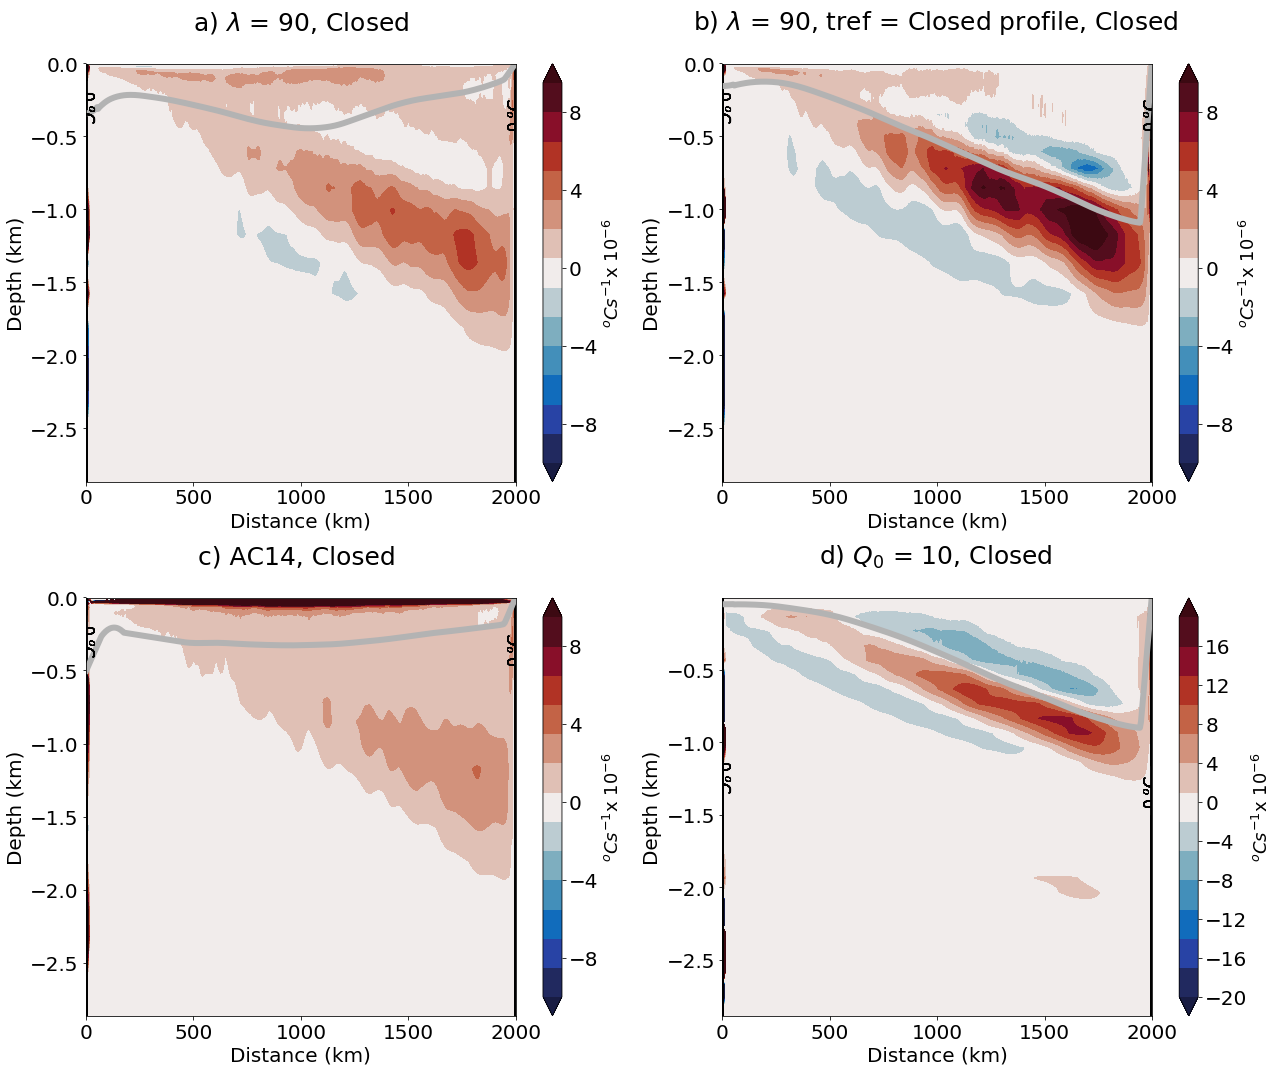

In [8]:
Psi_levs = np.arange(-2.5, 2.5, .2)+0.05
Psi_levs = np.arange(-2.5, 2.5, .2)+0.05
Psi_ticks =np.arange(-20., 20., 4)
fig = plt.figure(figsize=(18.0, 15.))
for i in range(len(Runs)):
    
    fname = x+str(Runs[i])
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNEL
    nopart = c. HFacC
    nopart[nopart<1] = 0
    ax = fig.add_subplot(2, 2, i+1)
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T*nopart
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH',mask=c.HFacS))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Sp[abs(Sp)<10**-5]=10**-5
    Sp[isinf(Sp)]=10**-5
    Sp[isnan(Sp)]=10**-5
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1,:,:])*CellVol[0:-1,:,:] 
    DE = ((c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[1::,:,:] 
          - (c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[0:-1,:,:])*CellVol[0:-1,:,:] 

    # Surf_corr_tend = (- WTHMASS(ix,iy)) / (DRF(1) * hFacC(ix,iy,1)
    Surcor = -(WTHMASS.mean(axis=0)).mean(axis=1)*c.dzf[0]
    npad = ((0, 1), (0, 0), (0, 0))
    DE = np.pad(DE, pad_width=npad, mode='constant', constant_values=0)

    Ade = np.pad(Ade, pad_width=npad, mode='constant', constant_values=0)
    ROC = -((Ade + dVTe + dVTbar + dWTbar).sum(axis=2))/sum(CellVol.mean(axis=2))
    # Tidy for boundary conditions
    ROC[0:3] = 0
    ROC[-1] = 0
    D = -(((DE )).sum(axis=2))/np.sum(CellVol.mean(axis=2) )
    scale =1
    if i==3:
        D*0.7
        ROC = ROC*0.7
        scale = 2
   
    p = ax.contourf(c.yc/1000, c.zc/1000,
                ROC*10**6, np.arange(-1,1,0.15)*10*scale, cmap=cmocean.cm.balance, extend='both')
    if i==3:
        q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc','THETA')/2, Q_levs, colors='k', linewidths=2)
    else:
        q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc','THETA'), Q_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=15)
    # Plot mixed layer depth via layer probability
    ax.set_xlim(0,2000)
    cbar=fig.colorbar(p, ax=ax,ticks=Psi_ticks)
    cbar.ax.tick_params(labelsize=20)
    cbar.ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=18, )
    # Plot mixed layer depth via layer probability
    val = 0
    if i==2:
        val=100
    mld = c.mnc('MLD.nc','MXLDEPTH')[0,:,:].mean(axis=1)
    mld[0:val] = np.linspace(200,mld[val],val)
    mld[0:val/4] = np.linspace(500,100,val/4)
    R = ax.plot(c.yc/1000, SG.savitzky_golay(-mld/1000, 21, 1), scalex=False,
                scaley=False, color='0.7', linestyle='-', linewidth=6)
    if str(Figletter[i])=='a) ':
        ax.set_title(str(Figletter[i])+r'$\lambda $ = 90, Closed'+'\n', fontsize=25)
    elif str(Figletter[i])=='b) ':
        ax.set_title(str(Figletter[i])+'$\lambda $ = 90, tref = Closed profile, Closed \n', fontsize=25)
    elif str(Figletter[i])=='c) ':
        ax.set_title(str(Figletter[i])+'AC14, Closed \n', fontsize=25)
    elif str(Figletter[i])=='d) ':
        ax.set_title(str(Figletter[i])+'$Q_0 $ = 10, Closed \n', fontsize=25)
    ax.set_xlabel('Distance (km)', fontsize=20)
    ax.set_ylabel(r'Depth (km)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()



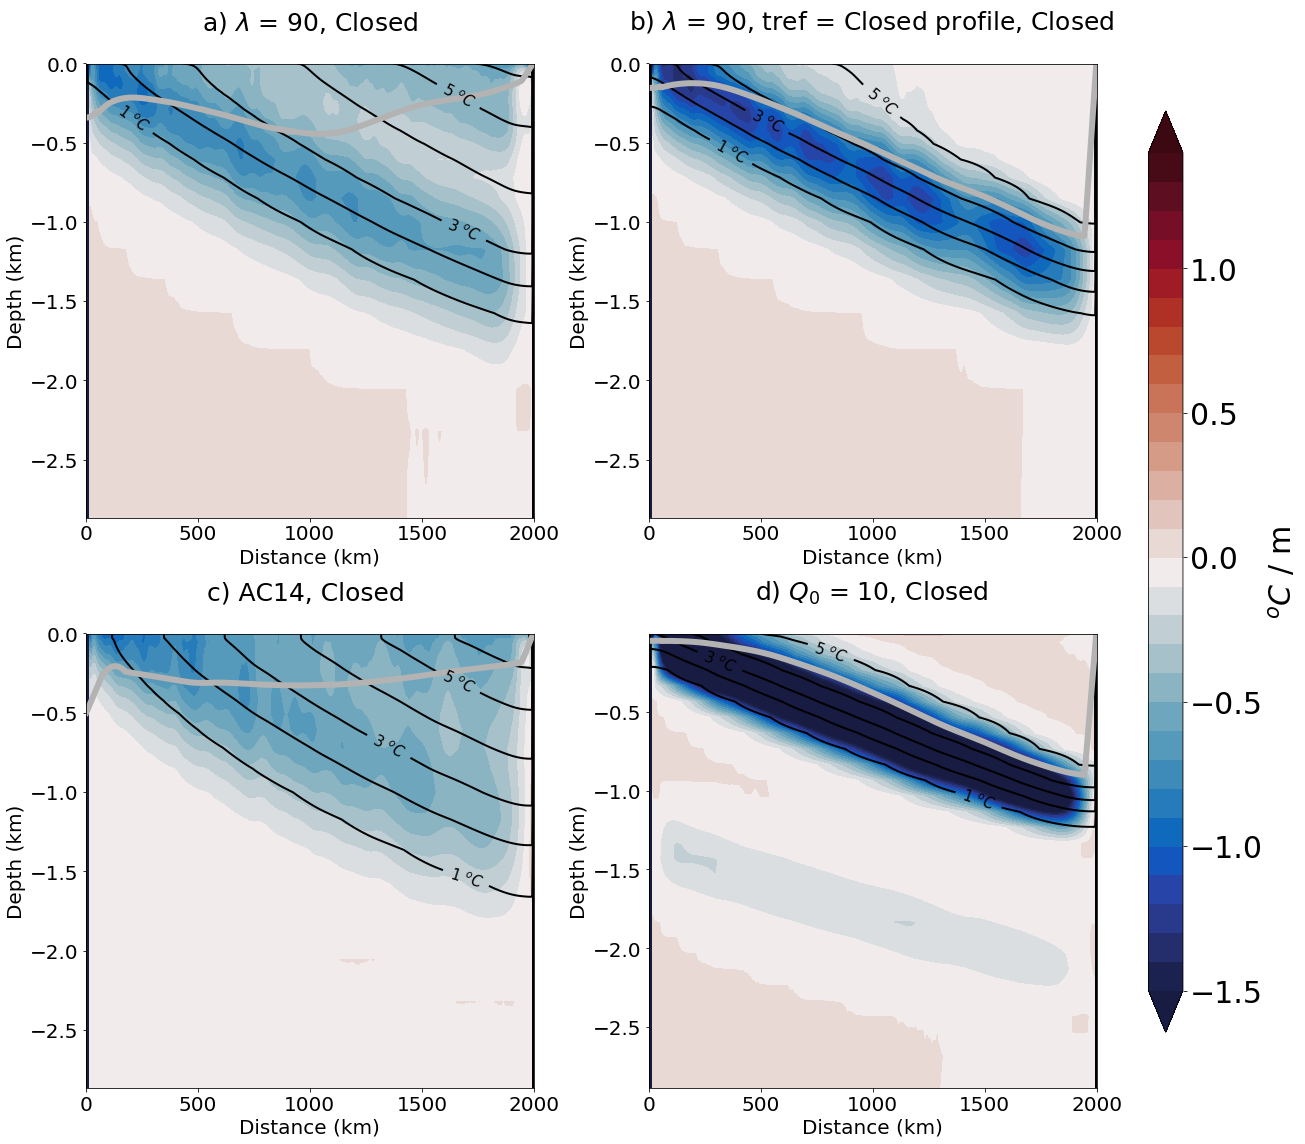

In [33]:
Psi_levs = np.arange(-2.5, 2.5, .2)+0.05
Psi_levs = np.arange(-2.5, 2.5, .2)+0.05
Psi_ticks =np.arange(-20., 20., 4)
fig = plt.figure(figsize=(16.0, 16.))
for i in range(len(Runs)):
    
    fname = x+str(Runs[i])
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNEL
    nopart = c. HFacC
    nopart[nopart<1] = 0
    ax = fig.add_subplot(2, 2, i+1)
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T*nopart
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH',mask=c.HFacS))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])/5000

    Ty_zone = Ty.sum(axis=2)

    scale =1
    if i==3:

        scale = 2
   
    p = ax.contourf(c.yc/1000, c.zc/1000,
                Ty_zone*10**3, np.arange(-1.5,1.5,0.1),cmap=cmocean.cm.balance, extend='both')
    if i==3:
        q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc','THETA')/2, Q_levs, colors='k', linewidths=2)
    else:
        q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc','THETA'), Q_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=15)
    ax.set_xlim(0,2000)
    # Plot mixed layer depth via layer probability
    val = 0
    if i==2:
        val=100
    mld = c.mnc('MLD.nc','MXLDEPTH')[0,:,:].mean(axis=1)
    mld[0:val] = np.linspace(200,mld[val],val)
    mld[0:val/4] = np.linspace(500,100,val/4)
    R = ax.plot(c.yc/1000, SG.savitzky_golay(-mld/1000, 21, 1), scalex=False,
                scaley=False, color='0.7', linestyle='-', linewidth=6)
    if str(Figletter[i])=='a) ':
        ax.set_title(str(Figletter[i])+r'$\lambda $ = 90, Closed'+'\n', fontsize=25)
    elif str(Figletter[i])=='b) ':
        ax.set_title(str(Figletter[i])+'$\lambda $ = 90, tref = Closed profile, Closed \n', fontsize=25)
    elif str(Figletter[i])=='c) ':
        ax.set_title(str(Figletter[i])+'AC14, Closed \n', fontsize=25)
    elif str(Figletter[i])=='d) ':
        ax.set_title(str(Figletter[i])+'$Q_0 $ = 10, Closed \n', fontsize=25)
    ax.set_xlabel('Distance (km)', fontsize=20)
    ax.set_ylabel(r'Depth (km)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=np.arange(-1.5,1.5,0.5))
cbar.ax.set_ylabel('$^oC$ / m', fontsize=30, )
cbar.ax.tick_params(labelsize=30)


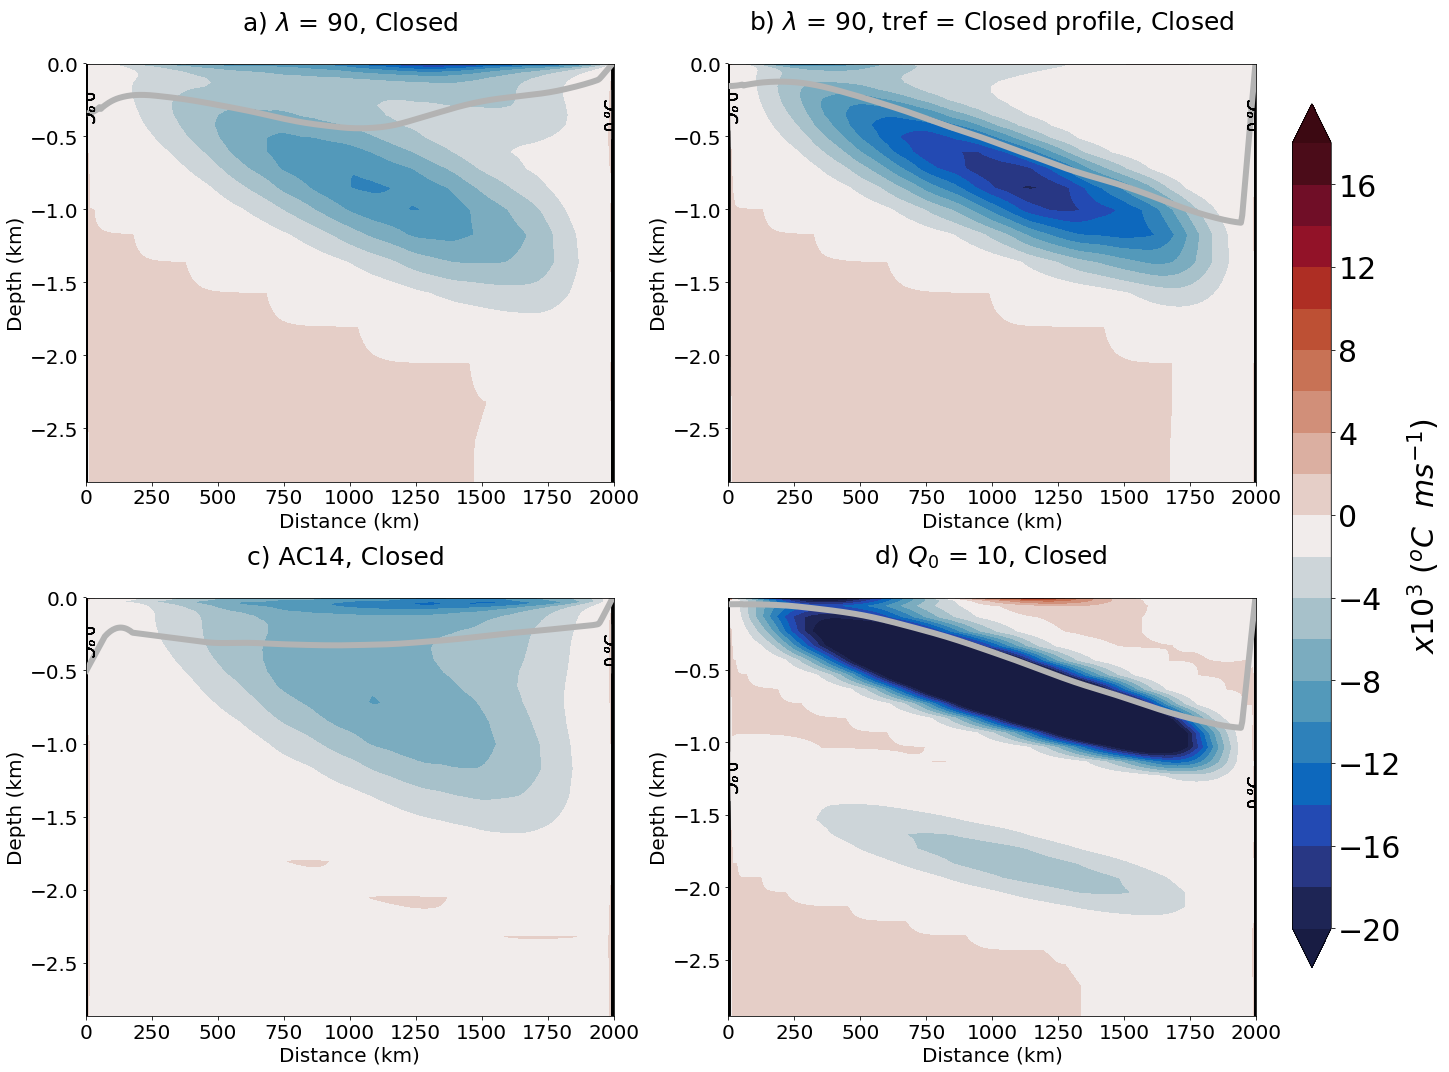

In [9]:
Psi_levs = np.arange(-2.5, 2.5, .2)+0.05
Psi_levs = np.arange(-2.5, 2.5, .2)+0.05
Psi_ticks =np.arange(-20., 20., 4)
fig = plt.figure(figsize=(18.0, 15.))
for i in range(len(Runs)):
    
    fname = x+str(Runs[i])
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNEL
    nopart = c. HFacC
    nopart[nopart<1] = 0
    ax = fig.add_subplot(2, 2, i+1)
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T*nopart
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH',mask=c.HFacS))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    
    # Surf_corr_tend = (- WTHMASS(ix,iy)) / (DRF(1) * hFacC(ix,iy,1)
    Surcor = -(WTHMASS.mean(axis=0)).mean(axis=1)*c.dzf[0]
    npad = ((0, 1), (0, 0), (0, 0))
    DE = np.pad(DE, pad_width=npad, mode='constant', constant_values=0)


    # Tidy for boundary conditions
    ROC[0:3] = 0
    ROC[-1] = 0
    D = -(((DE )).sum(axis=2))/np.sum(CellVol.mean(axis=2) )
    scale =1
    if i==3:
        D*0.7
        VpTp= VpTp#*0.6
        scale = 2
    VpTp[-1,:] = 0
    p = ax.contourf(c.yg/1000, c.zc/1000,
                VpTp.mean(axis=2)*1*10**3,np.arange(-20,20,2), cmap=cmocean.cm.balance, extend='both')
    if i==3:
        q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc','THETA')/2, Q_levs, colors='k', linewidths=2)
    else:
        q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc','THETA'), Q_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=15)
    # Plot mixed layer depth via layer probability
    val = 0
    if i==2:
        val=100
    mld = c.mnc('MLD.nc','MXLDEPTH')[0,:,:].mean(axis=1)
    mld[0:val] = np.linspace(200,mld[val],val)
    mld[0:val/4] = np.linspace(500,100,val/4)
    R = ax.plot(c.yc/1000, SG.savitzky_golay(-mld/1000, 21, 1), scalex=False,
                scaley=False, color='0.7', linestyle='-', linewidth=6)
    if str(Figletter[i])=='a) ':
        ax.set_title(str(Figletter[i])+r'$\lambda $ = 90, Closed'+'\n', fontsize=25)
    elif str(Figletter[i])=='b) ':
        ax.set_title(str(Figletter[i])+'$\lambda $ = 90, tref = Closed profile, Closed \n', fontsize=25)
    elif str(Figletter[i])=='c) ':
        ax.set_title(str(Figletter[i])+'AC14, Closed \n', fontsize=25)
    elif str(Figletter[i])=='d) ':
        ax.set_title(str(Figletter[i])+'$Q_0 $ = 10, Closed \n', fontsize=25)
    ax.set_xlabel('Distance (km)', fontsize=20)
    ax.set_ylabel(r'Depth (km)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=np.arange(-20,20,4))
cbar.ax.set_ylabel('$x10^{3}$ ($^oC$  $ms^{-1}$)', fontsize=30, )
cbar.ax.tick_params(labelsize=30)


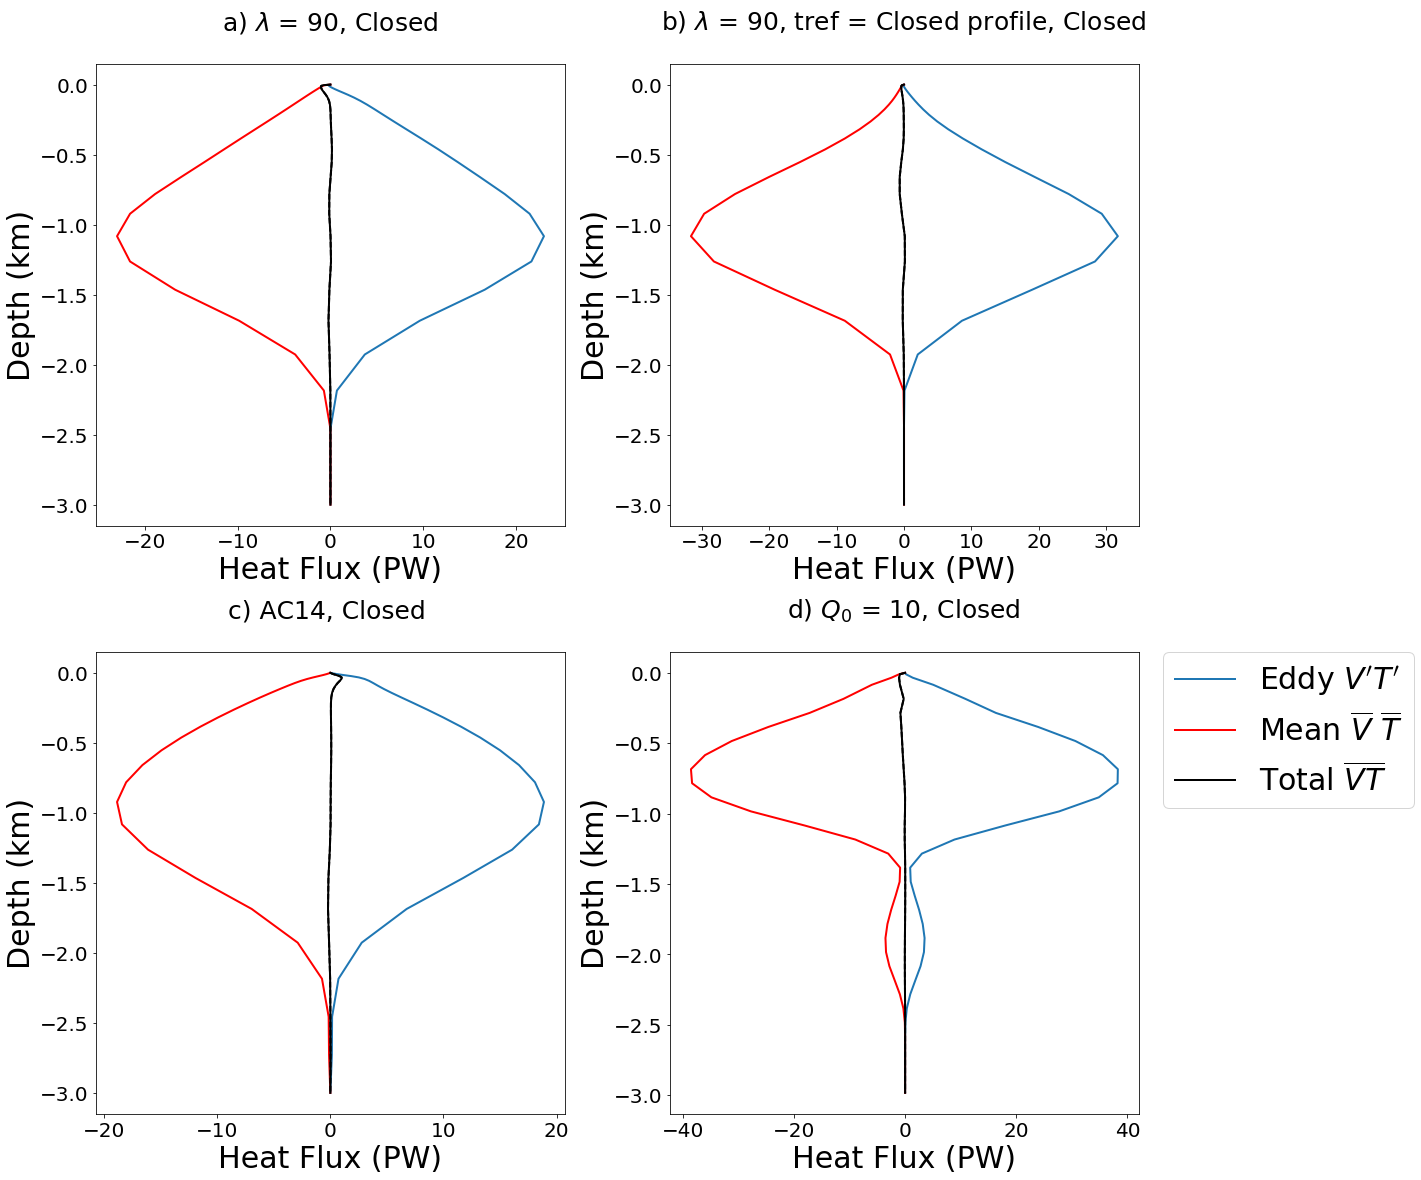

In [13]:
fig = plt.figure(figsize=(16.5, 16.5))
Q_levs = (arange(-.04,0.04,0.0021))
Q_ticks = np.arange(-.2, 0.2, .05)/10
for i in range(len(Runs)):
    #i =2 
    fname = x+str(Runs[i])
    c = utils.ChannelSetup(output_dir=str(fname))
    RAC = c.rac[0,0]*np.ones((c.Ny+1,c.Nx))
    CellVolv = RAC*tile(c.dzf,(c.Nx,c.Ny+1,1)).T
    CellVolw = c.rac*tile(c.dzc,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar                                                   
    # put everything on the C Grid                                                         
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    #Tw = np.pad(Tw, pad_width=npad, mode='constant', constant_values=0)
    VTbar = (V*Tv*CellVolv)
    WTbar = (W*Tw*CellVolw)
    VpTp = (VT*CellVolv - VTbar).mean(axis=2)
    WpTp = (WT*CellVolw - WTbar).mean(axis=2)
    VT = (VT*CellVolv).mean(axis=2)
    WT = (WT*CellVolw).mean(axis=2)
    VTbar = VTbar.mean(axis=2)
    WTbar = WTbar.mean(axis=2)
    MeanHF=1030*3985*(np.sum(WTbar,axis=1))/10**12
    EddyHF=1030*3985*(np.sum(WpTp,axis=1))/10**12
    TotalHF=1030*3985*(np.sum(WT,axis=1))/10**12
    THF=MeanHF+EddyHF
    ax = fig.add_subplot(2, 2, i+1)
    E,=ax.plot(EddyHF,c.zf/1000,linewidth=2)
    M,=ax.plot(MeanHF,c.zf/1000,'r',linewidth=2)
    T,=ax.plot(TotalHF,c.zf/1000,'k',linewidth=2)
    MEp,=ax.plot(THF,c.zf/1000,'--k',linewidth=2)
    if str(Figletter[i])=='a) ':
        ax.set_title(str(Figletter[i])+r'$\lambda $ = 90, Closed'+'\n', fontsize=25)
    elif str(Figletter[i])=='b) ':
        ax.set_title(str(Figletter[i])+'$\lambda $ = 90, tref = Closed profile, Closed \n', fontsize=25)
    elif str(Figletter[i])=='c) ':
        ax.set_title(str(Figletter[i])+'AC14, Closed \n', fontsize=25)
    elif str(Figletter[i])=='d) ':
        ax.set_title(str(Figletter[i])+'$Q_0 $ = 10, Closed \n', fontsize=25)
    
    ax.set_xlabel('Heat Flux (PW)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
lgd=legend([E,M,T],["Eddy $V'T'$","Mean $\overline{V}\,\,\overline{T}$",
                    "Total $\overline{VT}$"],bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.,  prop={'size': 30})
